# RNN从零开始编程

## 1. 下载数据

In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [15]:
# 字符对应的标号
vocab.token_to_idx

{'<unk>': 0,
 ' ': 1,
 'e': 2,
 't': 3,
 'a': 4,
 'i': 5,
 'n': 6,
 'o': 7,
 's': 8,
 'h': 9,
 'r': 10,
 'd': 11,
 'l': 12,
 'm': 13,
 'u': 14,
 'c': 15,
 'f': 16,
 'w': 17,
 'g': 18,
 'y': 19,
 'p': 20,
 'b': 21,
 'v': 22,
 'k': 23,
 'x': 24,
 'z': 25,
 'j': 26,
 'q': 27}

## 2. 初始化模型参数

In [23]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 3. 循环神经网络模型

为了定义循环神经网络模型， 我们首先需要一个`init_rnn_state`函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为`（批量大小，隐藏单元数）`。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。

In [24]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。 循环神经网络模型通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H。 此外，这里使用函数作为激活函数。 如 4.1节所述， 当元素在实数上满足均匀分布时，函数的平均值为0。

In [25]:
def rnn(inputs, state, params):
    '''
    RNN cell
    :param inputs: 批量输入特征 形状：(时间步数量，批量大小，词表大小)
    :param state: 初始状态
    :param params: 可学习参数
    :return: 当前的输出和当前的隐藏状态
    '''
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        # 时刻0的样本和样本字符列表，时刻1的样本和样本字符列表，...
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q  # 当前时刻的输入和隐变量预测出的下一时刻的输出
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数， 并存储从零开始实现的循环神经网络模型的参数

In [26]:
class RNNModelScratch:  #@save
    """从零开始实现的循环神经网络模型"""

    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        # forward_fn前向传播函数，这里可以传刚才定义的rnn函数

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状

In [28]:
num_hiddens = 512
net = RNNModelScratch(
    len(vocab),
    num_hiddens,
    d2l.try_gpu(),
    get_params,
    init_rnn_state,
    rnn
)

# 生成检查数据
X = torch.arange(10).reshape((2, 5))
# 初始化第0个隐藏状态
state = net.begin_state(X.shape[0], d2l.try_gpu())

Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 4. 预测

In [29]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """
    
    :param prefix: prefix是一个用户提供的包含多个字符的字符串，该函数根据这个prefix生成之后的字符串 
    :param num_preds: 需要生成的字符/字符串长度
    :param net: 网络模型
    :param vocab: 词汇表，根据vacab实现one-hot编码向字符的转变
    :param device: cpu或gpu
    :return: 生成的字符串
    """
    """在prefix后面生成新字符"""

    state = net.begin_state(batch_size=1, device=device)  # batch_size=1 是因为只要生成一个字符串
    outputs = [vocab[prefix[0]]]  # 只是把用户输入的字符对应的标号放在开头而已，并无特殊含义 e.g. [4, ]

    # 定义函数get_input()，每次拿到outputs的最后一个词，转换成tensor
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    # def get_input():
    #     return torch.tensor([outputs[-1]], device=device).reshape((1, 1))

    for y in prefix[1:]:  # 预热期，利用输入的prefix的信息不断完善隐状态state，并把完整的prefix存入outputs，并不在意预测值
        _, state = net(get_input(), state)
        outputs.append(vocab[y])  # e.g. [4, 3, 2, ...]

    # 预测num_preds步
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))  # 分类问题，找到len(vocab)个元素中最大的的下标，加入outputs

    return ''.join([vocab.idx_to_token[i] for i in outputs])  # vocab.idx_to_token[i]在词汇表中把标号转为字符，然后输出

现在我们可以测试predict_ch8函数。 我们将前缀指定为time traveller， 并基于这个前缀生成10个后续字符。 鉴于我们还没有训练网络，它会生成荒谬的预测结果。

In [31]:
predict_ch8(
    prefix='time traveller ',
    num_preds=10,
    net=net,
    vocab=vocab,
    device=d2l.try_gpu()
)

'time traveller djzyqrjzyq'

## 辅助函数：梯度裁剪

In [33]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""

    # 拿出所有需要学习的参数，即需要requires_grad==True
    if isinstance(net, nn.Module):  # 如果采用简洁写法nn.Module
        params = [p for p in net.parameters() if p.requires_grad]
    else:  # 如果采用从零开始实现的方法
        params = net.params

    # 先把所有的学习参数拼成一个向量，然后直接求L2范数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))

    if norm > theta:
        # 梯度太大，就把所有梯度同时缩放
        for param in params:
            param.grad[:] *= theta / norm

## 5. 开始训练

In [35]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    '''
    
    :param net: 模型
    :param train_iter: 数据 
    :param loss: 损失
    :param updater: 优化器
    :param device: cpu或gpu
    :param use_random_iter: True随机抽样，False顺序分区 
    :return: 困惑率 和 速度
    '''
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量

    # 计算图 x -> s -> y 如果s.detach_() 则 x, s -> y 且设置s.requires_grad=False 即y.backward时不会求s的梯度
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代初始化state 或 使用随机抽样时初始化state，因为对于随机抽样上一个state与这一次相互独立
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()

        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        # y_hat和y都是batch_size * nun_steps长的tensor
        l = loss(y_hat, y.long()).mean()

        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)  # 裁剪梯度 theta=1
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)

        # metric[0]存储总损失，metric[1]存储样本数量
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现， 也可以使用高级API来实现

In [37]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()  # 实际上就是分类模型

    # 画图
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])

    # 初始化
    # 优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)

    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)

    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            # 以'time traveller'为开头的训练
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])

    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')

    print(predict('time traveller'))  # 预测'time traveller'之后的生成
    print(predict('traveller'))  # 预测'traveller'之后的生成

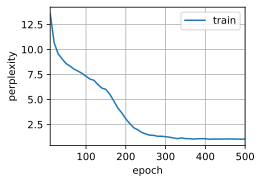

In [38]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [40]:
predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, d2l.try_gpu())
print(predict('time traveller'))

time travelleryou can show black is white by argument said filby


In [44]:
predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, d2l.try_gpu())
print(predict('traveller'))

travelleryou can show black is white by argument said filby


随机抽样方法的结果

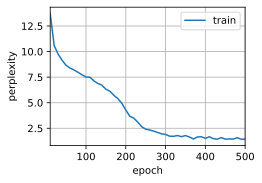

In [45]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)